# CIFAR10 Classification

In this part of the assignment we want to do an image classification task using PyTorch on CIFAR10 dataset.

## Import Libraries

Import needed libraries

In [ ]:
import matplotlib.pyplot as plt
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import tqdm

from time import time
from torchvision import transforms

## Device

Set device to work with (GPU or CPU)

In [ ]:
cuda = torch.device('cuda')

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Transforms & Dataset & Dataloader

Here, you should download and load the dataset with the desire transforms. After that, you should split train dataset to train and validation sets. Finally, define the dataloaders for `train`, `validation` and `test`

In [ ]:
def load_pure_trainset():
  pure_trainset = torchvision.datasets.CIFAR10(
      root='./data', 
      train=True,
      download=True, 
      transform=transforms.ToTensor())

  return pure_trainset

pure_trainset = load_pure_trainset()

Files already downloaded and verified


In [ ]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor

unorm = UnNormalize(mean=(0.49, 0.48, 0.45), std=(0.20, 0.19, 0.20))

In [ ]:
def load_trainset():
  transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4), 
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.49, 0.48, 0.45), (0.20, 0.19, 0.20))
  ])
  trainset = torchvision.datasets.CIFAR10(
      root='./data', 
      train=True,
      download=True, 
      transform=transform_train)

  return trainset


def split_val_data(trainset, train_ratio=0.9):
  train_size = int(train_ratio * len(trainset))
  val_size = len(trainset) - train_size

  train_set, val_set = torch.utils.data.random_split(trainset, (train_size, val_size))
  return train_set, val_set

def get_train_val_loader(train_set, val_set):
  trainloader = torch.utils.data.DataLoader(
      train_set, batch_size=256, shuffle=True, num_workers=2
      )
  valloader = torch.utils.data.DataLoader(
      val_set, batch_size=512, shuffle=True, num_workers=2
      )
  return trainloader, valloader
    

trainset = load_trainset()
train_set, val_set = split_val_data(trainset)
trainloader, valloader = get_train_val_loader(train_set, val_set)


Files already downloaded and verified


In [ ]:
def laod_testset():
  transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.49, 0.48, 0.45), (0.20, 0.19, 0.20))
  ])
  testset = torchvision.datasets.CIFAR10(
      root='./data', 
      train=False,
      download=True, 
      transform=transform_test)

  return testset

def get_test_loader(testset):
  testloader = torch.utils.data.DataLoader(
      testset, batch_size=512, shuffle=False, num_workers=2
      )
  return testloader


testset = laod_testset()
testloader = get_test_loader(testset)

Files already downloaded and verified


## Visualization

Visualize 5 random images from each class in different columns

- **Hint**:  You can use `plt.subplots` for visualization

In [ ]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

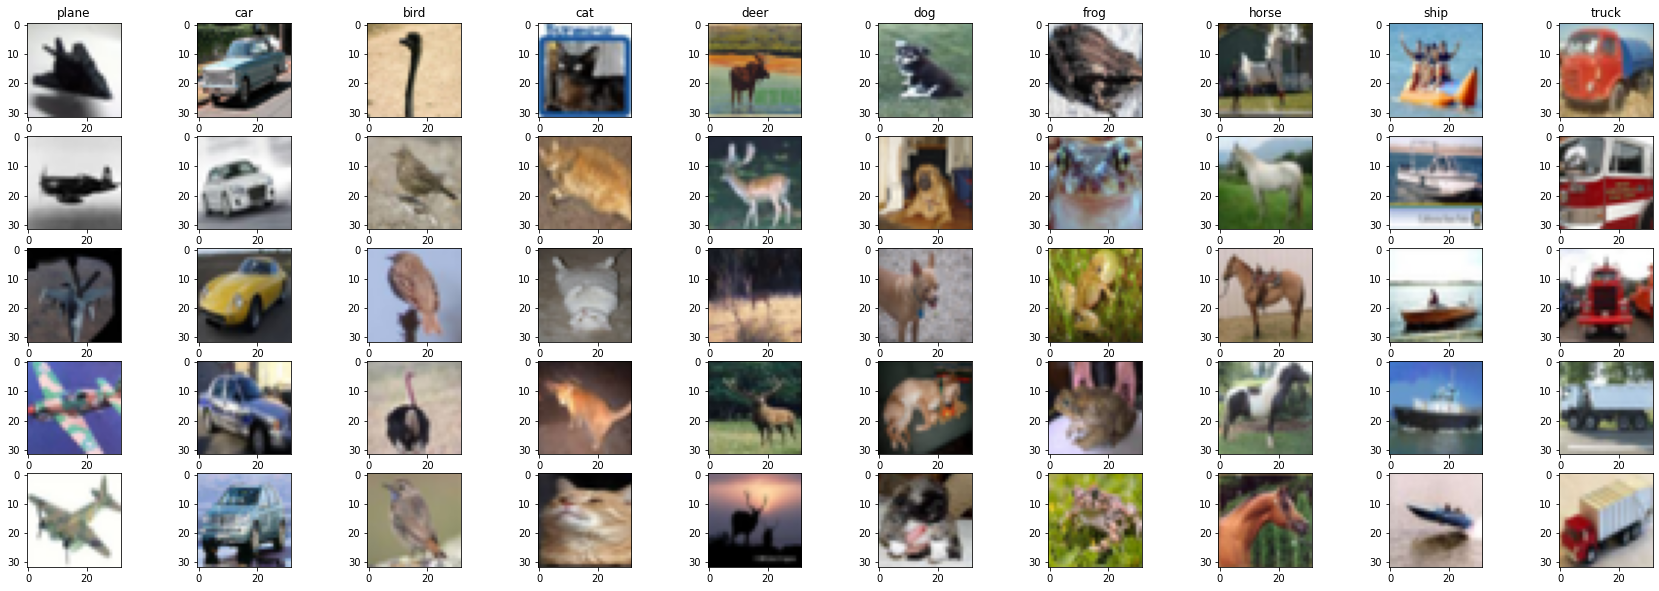

In [ ]:
fig = plt.figure(figsize=(30, 10))
ROW_COUNT = 5
sample_number = 0
for row in range(ROW_COUNT):
  sample_row = 1
  for class_number, class_type in enumerate(classes):
    while True:
      image, label = pure_trainset[sample_number]
      if label == class_number:
        fig.add_subplot(ROW_COUNT, 10, row * 10 + sample_row)
        plt.imshow(image.permute(1, 2, 0).numpy())
        sample_row += 1
        break
      sample_number += 1
    if row == 0:
      plt.title(class_type)
plt.show()

## Model

Define your model here from scratch (You are not allowed to use the existing models in pytorch)

**NOTICE:** The model that you will have defined outputs a vector containing 10 numbers (for each class). Define a "feature space" that is a vector of size *N* (where *N > 10*) right before the last layer (You can then have a last layer like `nn.Linear(N, 10)`). See the image below to get a better understanding. We will use this later (we want to access the feature space of a sample when the sample is given to the model). The model tries to learn a representation of the samples in this feature space and we will see how good it could do this in later sections.

![Feature Space In Neural Network](https://i.postimg.cc/28Qjcn9D/feature-space-vis.png)

- **Hint I**: Our goal is to get accuracy above *90%* on testset. Our suggestion is to implement ResNet (ResNet18 could be a viable choice)
  - You can learn the network's structure and implementation online (Youtube, ...) and then implmenet it yourself and make changes to enhance it's performance on our task **(YOU SHOULD NOT COPY THE CODE!!! OTHERWISE, YOU'LL BE PENALIZED!!!)**

- **Hint II**: When defining your model, pay attension to the **NOTICE** part in the above. It's also better to read the "Exploring the feature space" section beforehand.  

## Train

### Model instantiation

Create an instance of your model and move it to `device`

In [ ]:
class ResBlock(nn.Module):

    def __init__(self, in_planes, planes, stride=1):
        super(ResBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)

        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )
    def forward(self, x):
        out = self.bn2(self.conv2(F.relu(self.bn1(self.conv1(x)))))
        out = out + self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet18(nn.Module):
    def __init__(self, input_channels=3, num_classes=10):
        super(ResNet18, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)

        #Res Layer
        self.res_layer1 = self.make_resedual_block(64, stride=1)
        self.res_layer2 = self.make_resedual_block(128, stride=2)
        self.res_layer3 = self.make_resedual_block(256, stride=2)
        self.res_layer4 = self.make_resedual_block(512, stride=2)

        #Feature Vector
        self.linear = nn.Linear(512, num_classes)

    def make_resedual_block(self, planes, stride, num_block=2):
        strides = [stride] + [1] * (num_block - 1)
        layers = []
        for stride in strides:
            layers.append(ResBlock(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))

        out = self.res_layer1(out)
        out = self.res_layer2(out)
        out = self.res_layer3(out)
        out = self.res_layer4(out)

        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)

        out = self.linear(out)
        return out

In [ ]:
net = ResNet18()
net = net.to(device)

### Criterion & Optimizater

Define `criterion` and `optimizer` (Or `scheduler`)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-2, momentum=0.9)

### Train loop

Train your model 

Tasks:
- [ ] Things that are needed to be printed in each epoch:
  - Number of epoch
  - Train loss
  - Train accuracy
  - Validation loss
  - Validation accuracy
- [ ] save train/validation loss and accuracy (of each epoch) in an array for later usage

In [ ]:
train_loss = []
val_loss = []

train_acc = []
val_acc = []


def train_epoch(net: nn.Module, criterion: nn.Module, optimizer: torch.optim.Optimizer, dataloader: torch.utils.data.DataLoader):
  epoch_loss = 0
  epoch_true = 0
  epoch_all = 0
  i = 0

  net.train()
  with tqdm.tqdm(enumerate(dataloader), total=len(dataloader)) as pbar:
      for i, (x, y) in pbar:
          x = x.to(device)
          y = y.to(device)
          p = net(x)

          loss = criterion(p, y)
          epoch_loss += float(loss)

          predictions = p.argmax(-1)
          epoch_all += len(predictions)
          epoch_true += (predictions == y).sum()

          pbar.set_description(f'Loss: {epoch_loss / (i + 1):.3e} - Acc: {epoch_true * 100. / epoch_all:.2f}%')
          loss.backward()

          optimizer.step()
          optimizer.zero_grad()
  train_loss.append(epoch_loss / len(dataloader))
  train_acc.append((epoch_true * 100. / epoch_all).item())

def eval_epoch(net: nn.Module, criterion: nn.Module, dataloader: torch.utils.data.DataLoader):
  epoch_loss = 0
  epoch_true = 0
  epoch_all = 0
  i = 0

  net.eval()
  with torch.no_grad(), tqdm.tqdm(enumerate(dataloader), total=len(dataloader)) as pbar:
      for i, (x, y) in pbar:
          x = x.to(device)
          y = y.to(device)
          p = net(x)

          loss = criterion(p, y)
          epoch_loss += float(loss)

          predictions = p.argmax(-1)
          epoch_all += len(predictions)
          epoch_true += (predictions == y).sum()

          pbar.set_description(f'Loss: {epoch_loss / (i + 1):.3e} - Acc: {epoch_true * 100. / epoch_all:.2f}%')

  val_loss.append(epoch_loss / len(dataloader))
  val_acc.append((epoch_true * 100. / epoch_all).item())

In [ ]:
epochs = 80

for e in range(epochs):

    start_time = time()

    train_epoch(net, criterion, optimizer, trainloader)
    eval_epoch(net, criterion, valloader)

    end_time = time()

    print(f' Epoch {e+1:3} finished in {end_time - start_time:.2f}s')

Loss: 1.409e+00 - Acc: 51.88%: 100%|██████████| 10/10 [00:03<00:00,  3.09it/s]

 Epoch   1 finished in 41.16s



Loss: 1.012e+00 - Acc: 63.96%: 100%|██████████| 10/10 [00:02<00:00,  4.42it/s]

 Epoch   2 finished in 37.70s



Loss: 7.780e-01 - Acc: 72.94%: 100%|██████████| 10/10 [00:02<00:00,  4.43it/s]

 Epoch   3 finished in 38.25s



Loss: 8.086e-01 - Acc: 73.06%: 100%|██████████| 10/10 [00:02<00:00,  4.35it/s]

 Epoch   4 finished in 38.57s



Loss: 7.573e-01 - Acc: 75.46%: 100%|██████████| 10/10 [00:02<00:00,  4.40it/s]

 Epoch   5 finished in 38.94s



Loss: 6.664e-01 - Acc: 77.84%: 100%|██████████| 10/10 [00:02<00:00,  4.42it/s]

 Epoch   6 finished in 39.25s



Loss: 5.327e-01 - Acc: 82.06%: 100%|██████████| 10/10 [00:02<00:00,  4.12it/s]

 Epoch   7 finished in 39.55s



Loss: 5.848e-01 - Acc: 80.68%: 100%|██████████| 10/10 [00:02<00:00,  3.78it/s]

 Epoch   8 finished in 39.86s



Loss: 5.669e-01 - Acc: 80.90%: 100%|██████████| 10/10 [00:02<00:00,  4.43it/s]

 Epoch   9 finished in 39.34s



Loss: 4.997e-01 - Acc: 82.78%: 100%|██████████| 10/10 [00:02<00:00,  4.62it/s]

 Epoch  10 finished in 39.23s



Loss: 5.528e-01 - Acc: 82.88%: 100%|██████████| 10/10 [00:02<00:00,  4.20it/s]

 Epoch  11 finished in 39.54s



Loss: 4.422e-01 - Acc: 85.24%: 100%|██████████| 10/10 [00:02<00:00,  4.42it/s]

 Epoch  12 finished in 39.41s



Loss: 5.323e-01 - Acc: 82.94%: 100%|██████████| 10/10 [00:02<00:00,  4.41it/s]

 Epoch  13 finished in 39.39s



Loss: 5.400e-01 - Acc: 83.22%: 100%|██████████| 10/10 [00:02<00:00,  4.23it/s]

 Epoch  14 finished in 39.46s



Loss: 4.813e-01 - Acc: 84.60%: 100%|██████████| 10/10 [00:02<00:00,  4.36it/s]

 Epoch  15 finished in 39.48s



Loss: 4.226e-01 - Acc: 86.38%: 100%|██████████| 10/10 [00:02<00:00,  4.54it/s]

 Epoch  16 finished in 39.36s



Loss: 4.733e-01 - Acc: 84.62%: 100%|██████████| 10/10 [00:02<00:00,  4.40it/s]

 Epoch  17 finished in 39.33s



Loss: 6.036e-01 - Acc: 82.56%: 100%|██████████| 10/10 [00:02<00:00,  4.32it/s]

 Epoch  18 finished in 39.50s



Loss: 4.212e-01 - Acc: 86.80%: 100%|██████████| 10/10 [00:02<00:00,  4.40it/s]

 Epoch  19 finished in 39.39s



Loss: 3.843e-01 - Acc: 87.96%: 100%|██████████| 10/10 [00:02<00:00,  4.41it/s]

 Epoch  20 finished in 39.31s



Loss: 4.440e-01 - Acc: 86.68%: 100%|██████████| 10/10 [00:02<00:00,  4.30it/s]

 Epoch  21 finished in 39.45s



Loss: 4.260e-01 - Acc: 86.76%: 100%|██████████| 10/10 [00:02<00:00,  4.47it/s]

 Epoch  22 finished in 39.41s



Loss: 4.169e-01 - Acc: 87.04%: 100%|██████████| 10/10 [00:02<00:00,  4.59it/s]

 Epoch  23 finished in 39.26s



Loss: 4.602e-01 - Acc: 86.50%: 100%|██████████| 10/10 [00:02<00:00,  4.53it/s]

 Epoch  24 finished in 39.30s



Loss: 4.204e-01 - Acc: 87.44%: 100%|██████████| 10/10 [00:02<00:00,  4.24it/s]

 Epoch  25 finished in 39.47s



Loss: 3.783e-01 - Acc: 88.80%: 100%|██████████| 10/10 [00:02<00:00,  4.63it/s]

 Epoch  26 finished in 39.39s



Loss: 4.741e-01 - Acc: 86.96%: 100%|██████████| 10/10 [00:02<00:00,  4.48it/s]

 Epoch  27 finished in 39.37s



Loss: 4.783e-01 - Acc: 86.82%: 100%|██████████| 10/10 [00:02<00:00,  4.26it/s]

 Epoch  28 finished in 39.51s



Loss: 3.803e-01 - Acc: 89.56%: 100%|██████████| 10/10 [00:02<00:00,  4.41it/s]

 Epoch  29 finished in 39.49s



Loss: 4.898e-01 - Acc: 87.72%: 100%|██████████| 10/10 [00:02<00:00,  4.42it/s]

 Epoch  30 finished in 39.47s



Loss: 4.043e-01 - Acc: 88.70%: 100%|██████████| 10/10 [00:02<00:00,  4.26it/s]

 Epoch  31 finished in 39.40s



Loss: 4.815e-01 - Acc: 87.64%: 100%|██████████| 10/10 [00:02<00:00,  4.49it/s]

 Epoch  32 finished in 39.45s



Loss: 3.799e-01 - Acc: 89.46%: 100%|██████████| 10/10 [00:02<00:00,  4.43it/s]

 Epoch  33 finished in 39.49s



Loss: 5.294e-01 - Acc: 86.66%: 100%|██████████| 10/10 [00:02<00:00,  4.51it/s]

 Epoch  34 finished in 39.27s



Loss: 4.211e-01 - Acc: 88.64%: 100%|██████████| 10/10 [00:02<00:00,  4.25it/s]

 Epoch  35 finished in 39.51s



Loss: 3.823e-01 - Acc: 89.38%: 100%|██████████| 10/10 [00:02<00:00,  4.50it/s]

 Epoch  36 finished in 39.41s



Loss: 4.058e-01 - Acc: 89.46%: 100%|██████████| 10/10 [00:02<00:00,  4.46it/s]

 Epoch  37 finished in 39.38s



Loss: 4.144e-01 - Acc: 88.96%: 100%|██████████| 10/10 [00:02<00:00,  4.21it/s]

 Epoch  38 finished in 39.53s



Loss: 4.201e-01 - Acc: 89.06%: 100%|██████████| 10/10 [00:02<00:00,  4.50it/s]

 Epoch  39 finished in 39.47s



Loss: 4.481e-01 - Acc: 88.38%: 100%|██████████| 10/10 [00:02<00:00,  4.44it/s]

 Epoch  40 finished in 39.41s



Loss: 3.862e-01 - Acc: 89.76%: 100%|██████████| 10/10 [00:02<00:00,  4.30it/s]

 Epoch  41 finished in 39.41s



Loss: 4.337e-01 - Acc: 89.06%: 100%|██████████| 10/10 [00:02<00:00,  4.26it/s]

 Epoch  42 finished in 39.53s



Loss: 3.909e-01 - Acc: 90.34%: 100%|██████████| 10/10 [00:02<00:00,  4.46it/s]

 Epoch  43 finished in 39.42s



Loss: 3.942e-01 - Acc: 89.40%: 100%|██████████| 10/10 [00:02<00:00,  4.38it/s]

 Epoch  44 finished in 39.35s



Loss: 4.635e-01 - Acc: 88.62%: 100%|██████████| 10/10 [00:02<00:00,  4.36it/s]

 Epoch  45 finished in 39.47s



Loss: 4.551e-01 - Acc: 89.34%: 100%|██████████| 10/10 [00:02<00:00,  4.34it/s]

 Epoch  46 finished in 39.47s



Loss: 4.674e-01 - Acc: 89.00%: 100%|██████████| 10/10 [00:02<00:00,  4.50it/s]

 Epoch  47 finished in 39.33s



Loss: 4.486e-01 - Acc: 89.46%: 100%|██████████| 10/10 [00:02<00:00,  4.43it/s]

 Epoch  48 finished in 39.39s



Loss: 4.630e-01 - Acc: 89.14%: 100%|██████████| 10/10 [00:02<00:00,  4.48it/s]

 Epoch  49 finished in 39.36s



Loss: 4.343e-01 - Acc: 90.08%: 100%|██████████| 10/10 [00:02<00:00,  4.36it/s]

 Epoch  50 finished in 39.47s



Loss: 4.327e-01 - Acc: 90.24%: 100%|██████████| 10/10 [00:02<00:00,  4.42it/s]

 Epoch  51 finished in 39.40s



Loss: 4.153e-01 - Acc: 89.72%: 100%|██████████| 10/10 [00:02<00:00,  4.36it/s]

 Epoch  52 finished in 39.39s



Loss: 4.215e-01 - Acc: 90.18%: 100%|██████████| 10/10 [00:02<00:00,  4.54it/s]

 Epoch  53 finished in 39.44s



Loss: 4.233e-01 - Acc: 90.32%: 100%|██████████| 10/10 [00:02<00:00,  4.58it/s]

 Epoch  54 finished in 39.28s



Loss: 4.852e-01 - Acc: 89.30%: 100%|██████████| 10/10 [00:02<00:00,  4.35it/s]

 Epoch  55 finished in 39.42s



Loss: 4.266e-01 - Acc: 90.40%: 100%|██████████| 10/10 [00:02<00:00,  4.33it/s]

 Epoch  56 finished in 39.49s



Loss: 4.200e-01 - Acc: 90.44%: 100%|██████████| 10/10 [00:02<00:00,  4.35it/s]

 Epoch  57 finished in 39.42s



Loss: 4.418e-01 - Acc: 90.16%: 100%|██████████| 10/10 [00:02<00:00,  4.57it/s]

 Epoch  58 finished in 39.38s



Loss: 4.404e-01 - Acc: 90.16%: 100%|██████████| 10/10 [00:02<00:00,  4.46it/s]

 Epoch  59 finished in 39.34s



Loss: 4.759e-01 - Acc: 89.90%: 100%|██████████| 10/10 [00:02<00:00,  4.26it/s]

 Epoch  60 finished in 39.49s



Loss: 4.318e-01 - Acc: 90.52%: 100%|██████████| 10/10 [00:02<00:00,  4.25it/s]

 Epoch  61 finished in 39.53s



Loss: 4.021e-01 - Acc: 90.74%: 100%|██████████| 10/10 [00:02<00:00,  4.47it/s]

 Epoch  62 finished in 39.42s



Loss: 4.401e-01 - Acc: 90.60%: 100%|██████████| 10/10 [00:02<00:00,  4.30it/s]

 Epoch  63 finished in 39.45s



Loss: 4.536e-01 - Acc: 90.66%: 100%|██████████| 10/10 [00:02<00:00,  4.29it/s]

 Epoch  64 finished in 39.48s



Loss: 4.455e-01 - Acc: 90.86%: 100%|██████████| 10/10 [00:02<00:00,  4.55it/s]

 Epoch  65 finished in 39.43s



Loss: 4.276e-01 - Acc: 91.00%: 100%|██████████| 10/10 [00:02<00:00,  4.45it/s]

 Epoch  66 finished in 39.37s



Loss: 4.831e-01 - Acc: 90.10%: 100%|██████████| 10/10 [00:02<00:00,  4.60it/s]

 Epoch  67 finished in 39.31s



Loss: 4.572e-01 - Acc: 90.64%: 100%|██████████| 10/10 [00:02<00:00,  4.33it/s]

 Epoch  68 finished in 39.55s



Loss: 4.227e-01 - Acc: 90.64%: 100%|██████████| 10/10 [00:02<00:00,  4.44it/s]

 Epoch  69 finished in 39.35s



Loss: 4.511e-01 - Acc: 90.90%: 100%|██████████| 10/10 [00:02<00:00,  4.50it/s]

 Epoch  70 finished in 39.33s



Loss: 4.173e-01 - Acc: 91.14%: 100%|██████████| 10/10 [00:02<00:00,  4.25it/s]

 Epoch  71 finished in 39.48s



Loss: 4.686e-01 - Acc: 90.28%: 100%|██████████| 10/10 [00:02<00:00,  4.41it/s]

 Epoch  72 finished in 39.48s



Loss: 4.607e-01 - Acc: 90.86%: 100%|██████████| 10/10 [00:02<00:00,  4.35it/s]

 Epoch  73 finished in 39.37s



Loss: 4.039e-01 - Acc: 90.94%: 100%|██████████| 10/10 [00:02<00:00,  4.34it/s]

 Epoch  74 finished in 39.43s



Loss: 4.555e-01 - Acc: 90.58%: 100%|██████████| 10/10 [00:02<00:00,  4.35it/s]

 Epoch  75 finished in 39.57s



Loss: 4.616e-01 - Acc: 90.82%: 100%|██████████| 10/10 [00:02<00:00,  4.49it/s]

 Epoch  76 finished in 39.31s



Loss: 4.236e-01 - Acc: 91.24%: 100%|██████████| 10/10 [00:02<00:00,  4.25it/s]

 Epoch  77 finished in 39.49s



Loss: 4.106e-01 - Acc: 91.56%: 100%|██████████| 10/10 [00:02<00:00,  4.39it/s]

 Epoch  78 finished in 39.47s



Loss: 4.711e-01 - Acc: 90.58%: 100%|██████████| 10/10 [00:02<00:00,  4.47it/s]

 Epoch  79 finished in 39.50s



Loss: 4.732e-01 - Acc: 90.60%: 100%|██████████| 10/10 [00:02<00:00,  4.44it/s]

 Epoch  80 finished in 39.38s


### Visualize Loss and Accuracy plot

Using the arrays that you have (from task 2 in the above section), visualize two plots: Accuracy plot (train and validation together) and Loss plot (train and validation together)

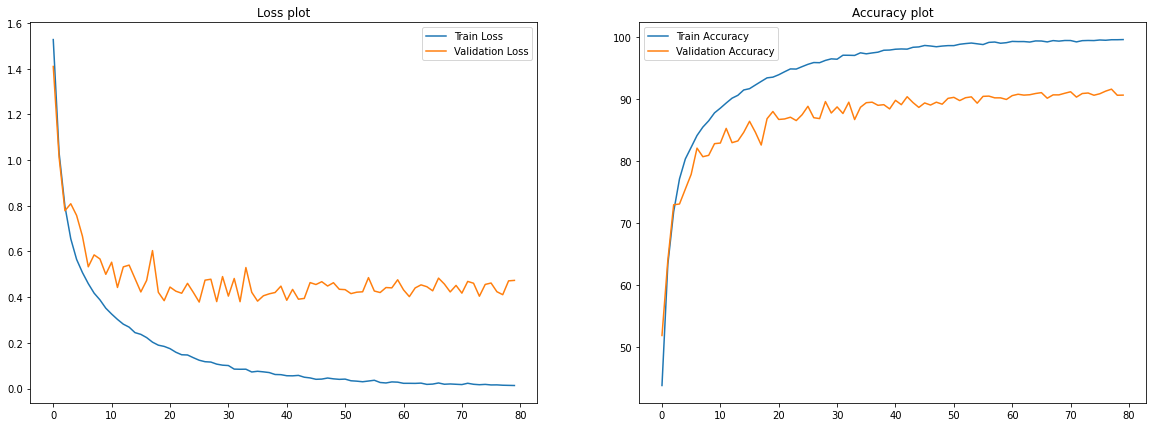

In [ ]:
epoch_list = [i for i in range(epochs)]

fig = plt.figure(figsize=(20, 7))

fig.add_subplot(1, 2, 1)
plt.plot(epoch_list, train_loss)
plt.plot(epoch_list, val_loss)
plt.title('Loss plot')
plt.legend(['Train Loss', 'Validation Loss'])

fig.add_subplot(1, 2, 2)
plt.plot(epoch_list, train_acc)
plt.plot(epoch_list, val_acc)
plt.title('Accuracy plot')
plt.legend(['Train Accuracy', 'Validation Accuracy'])

plt.show()

## Evaluation

Test your trained model (using the Test Dataloader that you have). Our goal is to reach an accuracy above `90%`

In [ ]:
eval_epoch(net, criterion, testloader)

Loss: 5.511e-01 - Acc: 91.03%: 100%|██████████| 20/20 [00:03<00:00,  6.22it/s]


## Visualize incorrectly predicted samples from testset

Visualize *24* random images from testset that are incorrectly predicted by the model

In [ ]:
net.eval()
wrong_prediction = []

x_list = []
feature_set = []
handle = net.linear.register_forward_hook(lambda m, i, o: feature_set.append(i[0]))

with torch.no_grad(), tqdm.tqdm(enumerate(testloader), total=len(testloader)) as pbar:
  for i, (x, y) in pbar:
    x = x.to(device)
    y = y.to(device)
    p = net(x)

    predictions = p.argmax(-1)
    for x_pred, y_true, y_pred, feature in zip(x, y, predictions, feature_set[i - 1]):
      if y_pred != y_true:
        wrong_prediction.append((x_pred.to('cpu'), y_pred.to('cpu'), y_true.to('cpu'), feature))

handle.remove()

100%|██████████| 20/20 [00:03<00:00,  5.73it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


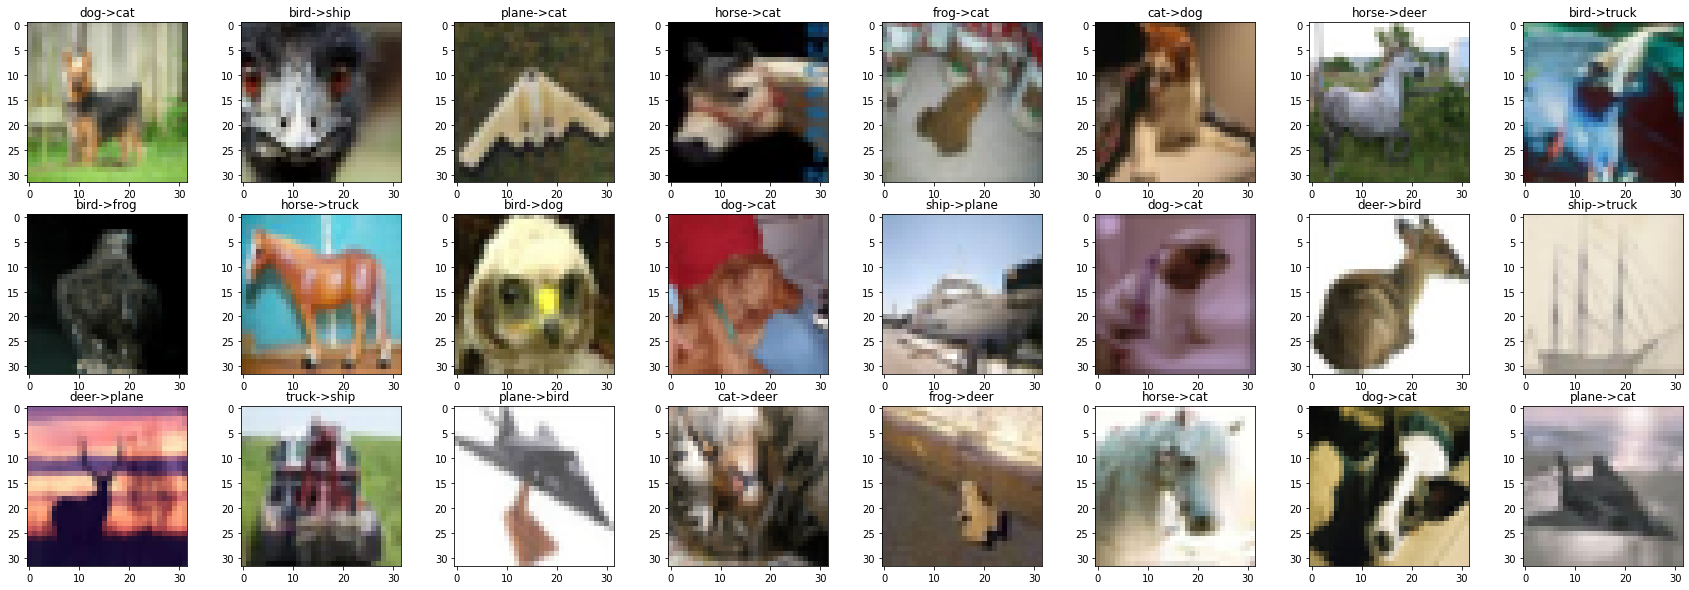

In [ ]:
import numpy
fig = plt.figure(figsize=(30, 10))
wrong_sample_count = 1
for wrong in wrong_prediction:
  image, pred_label, true_label, _ = wrong
  fig.add_subplot(3, 8, wrong_sample_count)
  plt.imshow(unorm(image.clone().detach()).permute(1, 2, 0).numpy())
  plt.title(f"{classes[true_label]}->{classes[pred_label]}")
  wrong_sample_count +=1
  if wrong_sample_count > 24:
    break
plt.show()

## Exploring the feature space

### Calculate the feature space for all training samples

You have trained and evaluated your model. Now, for each sample in the trainset, calculate it's "feature space" discussed in the model section. The result of this section should be a tensor of size `(50000, N)` saved in a variable (for later usage)

- **Hint 1:** define a tensor with dimension `(50000, N)` where *50000* is the size of the trainset and *N* is the dimension of the feature space

- **Hint 2:** Pay attension to the `shuffle` attribute of your train dataloader (If needed)

In [ ]:
x_list = []
y_list = []
feature_set = []
handle = net.linear.register_forward_hook(lambda m, i, o: feature_set.append(i[0]))

net.eval()
with torch.no_grad(), tqdm.tqdm(enumerate(trainloader), total=len(trainloader)) as pbar:
      for i, (x, y) in pbar:
          x = x.to(device)
          y = y.to(device)
          y_list.append(y)
          p = net(x)
          x_list.append(x)
handle.remove()

data_feature_list = []

for datas, labels, feature in zip(x_list, y_list, feature_set):
  data_feature_list = data_feature_list + [(data, feature_epoch, label) for data, feature_epoch, label in zip(datas, feature, labels)]

len(data_feature_list)

100%|██████████| 176/176 [00:17<00:00, 10.33it/s]


45000

### K Nearest Neighbor in feature space

You already have calculated the feature spaces for trainset ($S$) in the previous section

1. Get 5 random samples from testset which are correctly predicted by the model. 
2. for each sample, calculate it's "feature space" ($X$)
3. for each sample, calculate it's *5* nearest neighbors in "feature space" in the trainset (by comparing $X$ to each row in $S$) and visualize them

**Note:** Your visualization should be something like the below picture

**Hint:** For finding the nearest neighbors in the feature space you can use `torch.linalg.norm` and `torch.topk`

In [25]:
true_prediction_data_label_feature = []
feature_set = []

net.eval()
handle = net.linear.register_forward_hook(lambda m, i, o: feature_set.append(i[0]))
with torch.no_grad(), tqdm.tqdm(enumerate(testloader), total=len(testloader)) as pbar:
  for i, (x, y) in pbar:
    x = x.to(device)
    y = y.to(device)
    p = net(x)
    predictions = p.argmax(-1)
    for x_pred, y_true, y_pred, feature in zip(x, y, predictions, feature_set[i]):
      if y_pred == y_true:
        true_prediction_data_label_feature.append((x_pred.to('cpu'), y_true.to('cpu'), feature))

handle.remove()

100%|██████████| 20/20 [00:04<00:00,  4.51it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

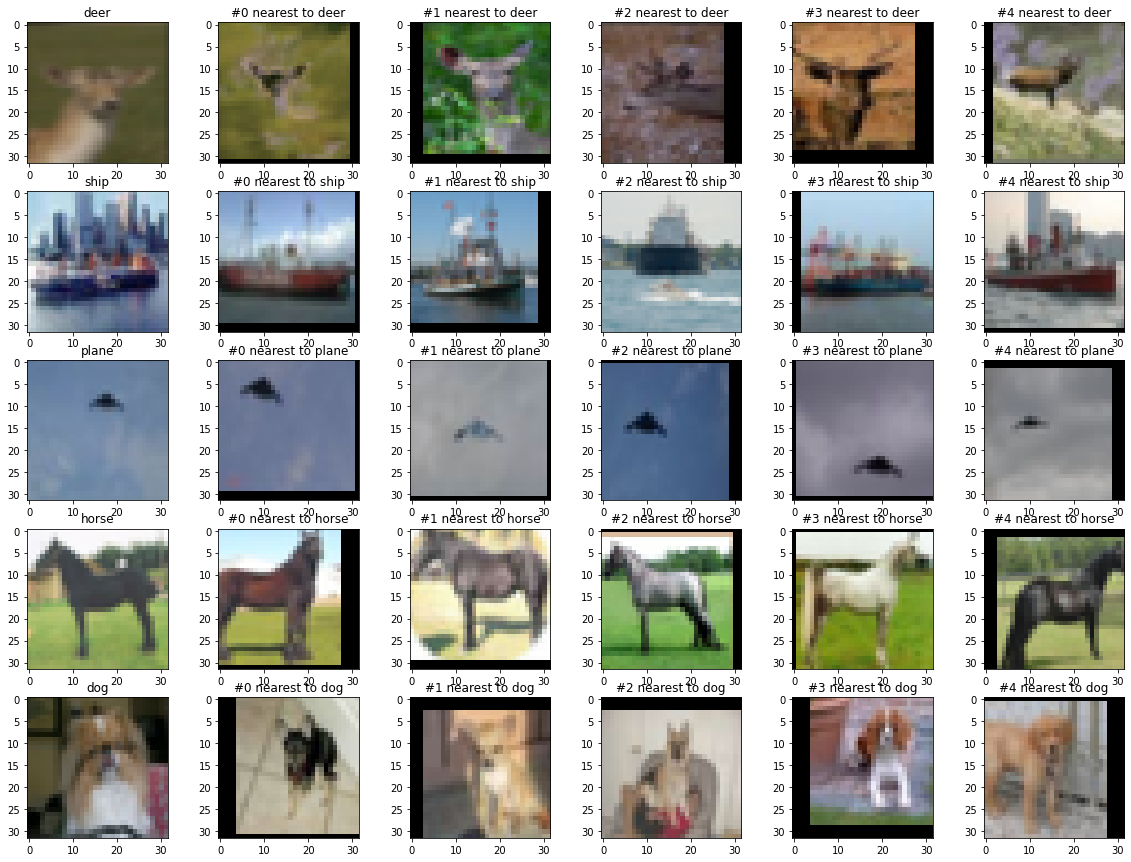

In [ ]:
from random import sample
fig = plt.figure(figsize=(20, 15))


for index, each_true_prediction_data_label_feature in enumerate(sample(true_prediction_data_label_feature, 5)):
  distance_list = []

  for each_data_feature_list in data_feature_list:
    distance = torch.linalg.norm(each_true_prediction_data_label_feature[2] - each_data_feature_list[1])
    distance_list.append((distance, each_data_feature_list[0]))
  
  distance_list.sort(key=lambda x: x[0])
  distance_list_test = distance_list[:5]
  fig.add_subplot(5, 6, index * 6 + 1)
  
  plt.imshow(unorm(each_true_prediction_data_label_feature[0].clone().detach()).permute(1, 2, 0).numpy())
  plt.title(classes[each_true_prediction_data_label_feature[1]])
  
  for index_col, image in enumerate(distance_list_test):
    fig.add_subplot(5, 6, index * 6 + index_col + 2)
    plt.imshow(unorm(image[1].to('cpu').clone().detach()).permute(1, 2, 0).numpy())
    plt.title(f"#{index_col} nearest to {classes[each_true_prediction_data_label_feature[1]]}")

plt.show()

### TSNE 

1. Sample $M$ ($2000$ would be enought) random samples from the trainset feature space (calculated in the above sections) 
2. Now you a vector of size `(M, N)` where $N$ is the dimension of the feature space
3. Using TSNE reduce $N$ to $2$ (Now you have a vector of size `(M, 2)`)
4. Print the shape of the output

**Hint:** You can use `sklearn.manifold.TSNE`

In [ ]:
import numpy as np

sample_for_tsne = sample(data_feature_list, 2000)
sample_feature = [feature[1].to('cpu').numpy() for feature in sample_for_tsne]
sample_y = [int(feature[2].to('cpu')) for feature in sample_for_tsne]
len(sample_feature)

2000

In [28]:
import numpy as np
from sklearn.manifold import TSNE
X = np.array([[0, 0, 0], [0, 1, 1], [1, 0, 1], [1, 1, 1]])
X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random').fit_transform(np.array(sample_feature))
X_embedded.shape

(2000, 2)

Visualize the points in a 2D plane (Set color of each point based on it's class)

**Notice:** Your visualization should be something like the below image

**Hint:** Use `plt.scatter(x, y, c=labels)`

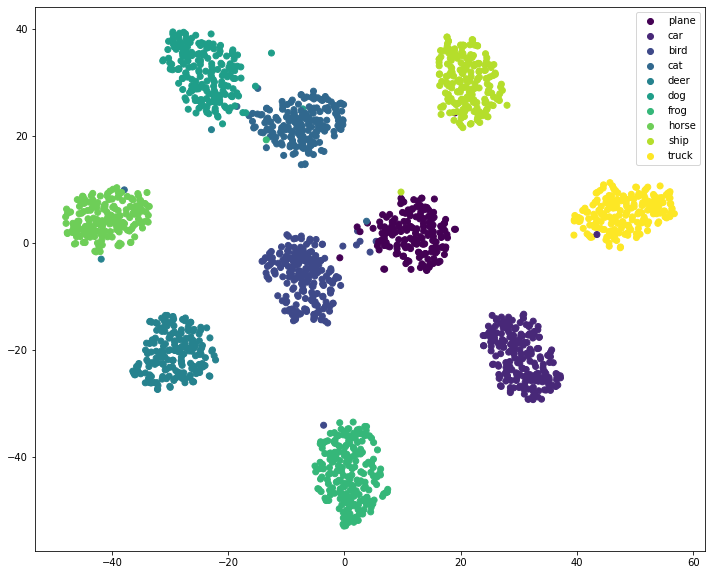

In [68]:
x_for_plot = [x_embedded[0] for x_embedded in X_embedded]
y_for_plot = [y_embedded[1] for y_embedded in X_embedded]

fig, ax = plt.subplots(figsize=(12, 10))
handles_scatter = ax.scatter(X_embedded[:,0], X_embedded[:,1], c=sample_y)
plt.legend(handles=handles_scatter.legend_elements()[0], labels=classes)
plt.show()